In [13]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats



In [2]:
# Presupunem că fișierul 'greutati.csv' conține o coloană 'weight' cu valorile greutăților peștilor
# Ajustează numele fișierului și coloana la structura ta reală de date

print("Loading data from 'greutati.csv'...")
df = pd.read_csv('greutati.csv')
weights = df['Greutate_pește'].values  # vector numpy de greutăți
print(f"Loaded {len(weights)} data points.")


Loading data from 'greutati.csv'...
Loaded 200 data points.


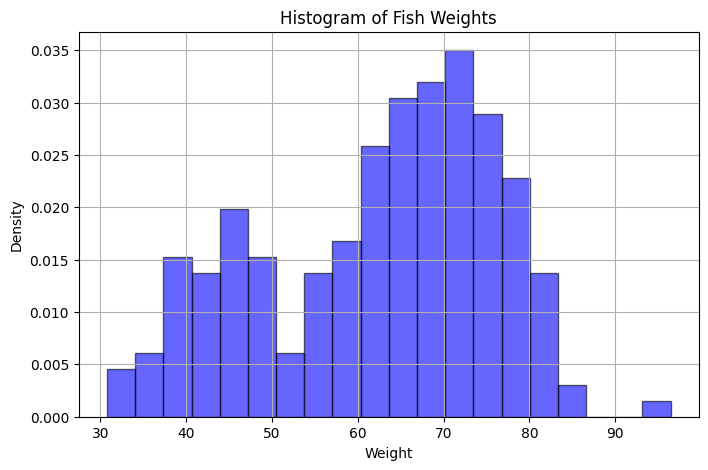

In [7]:
plt.figure(figsize=(8,5))
plt.hist(weights, bins=20, density=True, alpha=0.6, color='blue', edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Density')
plt.title('Histogram of Fish Weights')
plt.grid(True)
plt.show()


In [16]:
def create_and_sample_mixture_model(K, data):
    """
    Creează un mixture model normal cu K subpopulații
    și rulează un sample MCMC foarte scurt (test).
    Returnează InferenceData (trace) și obiectul modelului.
    """
    print(f"\n=== Building Mixture Model with K={K} ===")

    with pm.Model() as model:
        # Prior pentru ponderi (Dirichlet)
        w = pm.Dirichlet('w', a=np.ones(K), shape=K)

        # Prior pentru medii (Normal)
        mu = pm.Normal('mu', mu=0, sigma=10, shape=K)

        # Prior pentru deviații standard (HalfNormal)
        sigma = pm.HalfNormal('sigma', sigma=10, shape=K)

        # Folosim pm.NormalMixture care e mai nou in PyMC
        # Observăm datele 'data' prin acest mixture
        y_obs = pm.NormalMixture(
            'y_obs',
            w=w,
            mu=mu,
            sigma=sigma,
            observed=data
        )

        # Sampling foarte scurt, doar pentru a testa că merge
        # În aplicații reale, tune și draws mai mari!
        print(f"Sampling for K={K} ... (short run)")
        trace = pm.sample(
            draws=10,         # FOARTE mic, doar să vedem că rulează
            tune=10,          # FOARTE mic, doar să vedem că rulează
            chains=2,         # numărul de lanțuri
            target_accept=0.8,
            return_inferencedata=True,
            idata_kwargs={"log_likelihood": True}  # necesar pentru compare
        )

    return trace, model



=== Plotting Fixed Mixture Model for K=3 ===


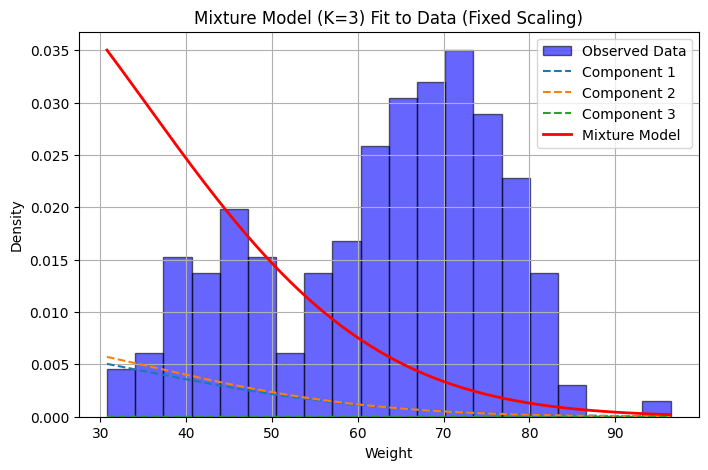


=== Plotting Fixed Mixture Model for K=4 ===


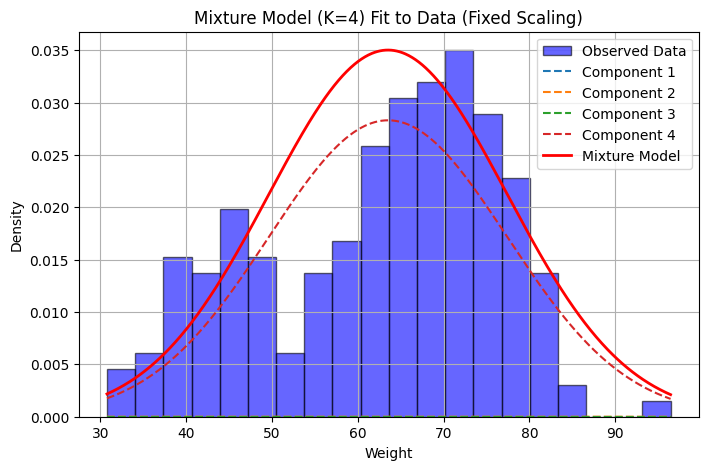


=== Plotting Fixed Mixture Model for K=5 ===


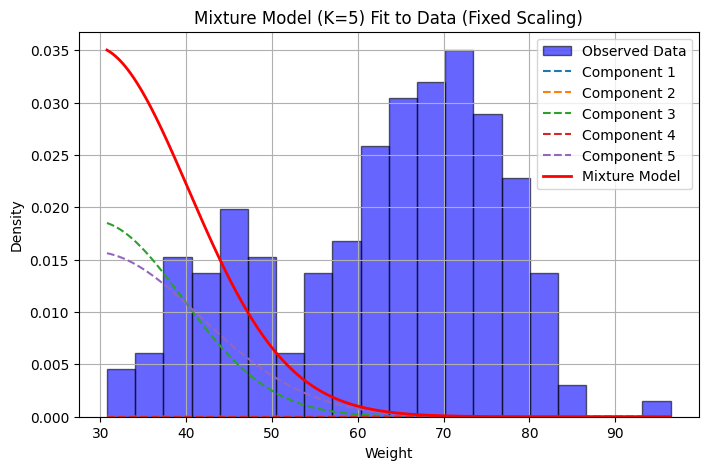

In [17]:
models_traces = {}
models_objs = {}

for k in [3, 4, 5]:
    idata, model = create_and_sample_mixture_model(k, weights)
    models_traces[f"K={k}"] = idata
    models_objs[f"K={k}"] = model



=== Model Comparison (WAIC) ===
     rank    elpd_waic     p_waic   elpd_diff        weight         se  \
K=4     0  1635.196608   7.382623    0.000000  9.995854e-01  16.528997   
K=5     1  1653.273505  12.186558   18.076897  4.145829e-04  14.939199   
K=3     2  2102.005566  12.876226  466.808958  2.451998e-88   7.993281   

           dse  warning     scale  
K=4   0.000000     True  deviance  
K=5   3.289809    False  deviance  
K=3  20.505234    False  deviance  


C:\Users\Victus\PycharmProjects\PMP-2024\.venv1\lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


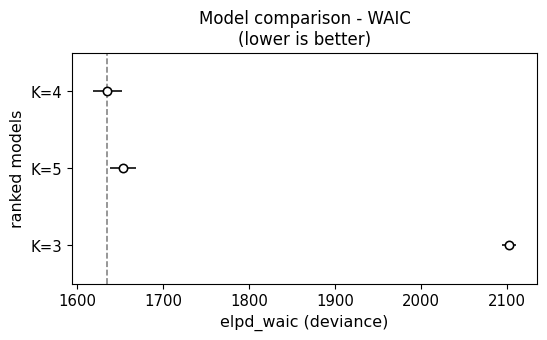


=== Model Comparison (LOO) ===
     rank     elpd_loo      p_loo   elpd_diff        weight         se  \
K=4     0  1635.348183   7.458410    0.000000  9.997452e-01  16.649126   
K=5     1  1655.102573  13.101093   19.754391  2.547796e-04  14.911687   
K=3     2  2102.170876  12.958881  466.822694  8.357737e-91   8.126415   

           dse  warning     scale  
K=4   0.000000     True  deviance  
K=5   3.351998     True  deviance  
K=3  20.526854     True  deviance  


C:\Users\Victus\PycharmProjects\PMP-2024\.venv1\lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.23 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\Victus\PycharmProjects\PMP-2024\.venv1\lib\site-packages\arviz\stats\stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.23 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\Victus\PycharmProjects\PM

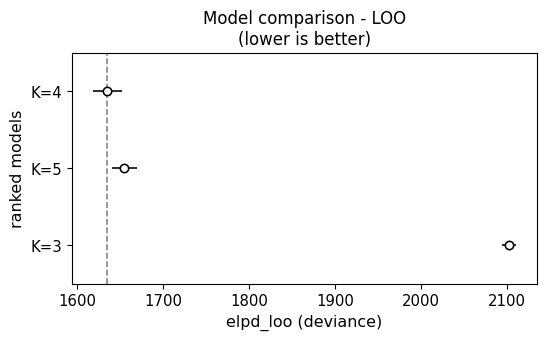

In [6]:
print("\n=== Model Comparison (WAIC) ===")
comparison_waic = az.compare(
    models_traces,  # Pass the dictionary directly
    method='BB-pseudo-BMA',
    ic='waic',
    scale='deviance'
)
print(comparison_waic)

az.plot_compare(comparison_waic)
plt.title("Model comparison - WAIC\n(lower is better)")
plt.show()


print("\n=== Model Comparison (LOO) ===")
comparison_loo = az.compare(
    models_traces,  # Pass the dictionary directly
    method='BB-pseudo-BMA',
    ic='loo',
    scale='deviance'
)
print(comparison_loo)

az.plot_compare(comparison_loo)
plt.title("Model comparison - LOO\n(lower is better)")
plt.show()
